In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import f3dasm
from f3dasm import AugmentedFunction, Data
from f3dasm.base import function

dim = 1
iterations = 10
seed = 123
numbers_of_samples = [20, 5]
budget = 5

fidelity_parameters = [0.5, 1.]
costs = [0.5, 1.]

base_fun = f3dasm.functions.Schwefel(
    dimensionality=dim,
    scale_bounds=np.tile([0.0, 1.0], (dim, 1)),
    )

fidelity_functions = []
multifidelity_samplers = []

for i, fidelity_parameter in enumerate(fidelity_parameters):

    fun = AugmentedFunction(
            base_fun=base_fun,
            fid=fidelity_parameter,
            )
    
    parameter_DesignSpace = f3dasm.make_nd_continuous_design(
        bounds=np.tile([0.0, 1.0], (dim, 1)),
        dimensionality=dim,
    )
    fidelity_parameter = f3dasm.ConstantParameter(name="fid", constant_value=fidelity_parameter)
    parameter_DesignSpace.add_input_space(fidelity_parameter)

    sampler = f3dasm.sampling.SobolSequence(design=parameter_DesignSpace)

    fidelity_functions.append(fun)
    multifidelity_samplers.append(sampler)

multifidelity_function = function.MultiFidelityFunction(
    fidelity_functions=fidelity_functions,
    fidelity_parameters=fidelity_parameters,
    costs=costs,
)

optimizer = f3dasm.optimization.MFBayesianOptimizationTorch(
    data=f3dasm.Data(design=parameter_DesignSpace),
    multifidelity_function=multifidelity_function,
)

optimizer.init_parameters()
optimizer.parameter.noise_fix = True

res = f3dasm.run_multi_fidelity_optimization(
    optimizer=optimizer,
    multifidelity_function=multifidelity_function,
    multifidelity_samplers=multifidelity_samplers,
    iterations=iterations,
    seed=123,
    numbers_of_samples=numbers_of_samples,
    budget=budget,
)

2022-12-01 15:21:21.482039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 15:21:21.624328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-01 15:21:21.624348: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-01 15:21:21.659492: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-01 15:21:22.264050: W tensorflow/stream_executor/platform/de

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy
iteration 0
cumulative cost 0.0
[[1.  0.5]] [[299.78602927]]
This iteration cost: 0.5
iteration 1
cumulative cost 0.5
[[0.  0.5]] [[119.19687073]]
This iteration cost: 0.5
iteration 2
cumulative cost 1.0
[[0.  0.5]] [[119.19687073]]
This iteration cost: 0.5
iteration 3
cumulative cost 1.5
[[1.  0.5]] [[299.78602927]]
This iteration cost: 0.5
iteration 4
cumulative cost 2.0
[[0.  0.5]] [[119.19687073]]
This iteration cost: 0.5
iteration 5
cumulative cost 2.5
[[0.  0.5]] [[119.19687073]]
This iteration cost: 0.5
iteration 6
cumulative cost 3.0
[[0.  0.5]] [[119.19687073]]
This iteration cost: 0.5
iteration 7
cumulative cost 3.5
[[0.  0.5]] [[119.19687073]]
This iteration cost: 0.5
iteration 8
cumulative cost 4.0
[[0.  0.5]] [[119.19687073]]
This iteration co

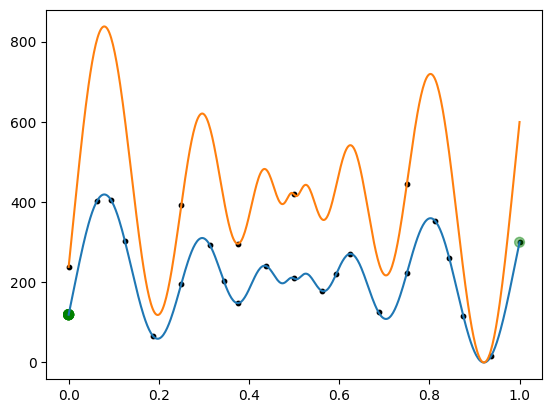

In [2]:
hist_data = res[-1].data.loc[np.sum(numbers_of_samples):]

hist_data_low = hist_data[hist_data['input', 'fid'] != 1.]
hist_data_high = hist_data[hist_data['input', 'fid'] == 1.]

if dim == 1:
    x_plot = np.linspace(0, 1, 500)[:, None]

    for i, fid_i in enumerate(fidelity_parameters):
        fid_plot = fid_i * np.ones_like(x_plot)
        x_fid_plot = np.hstack((x_plot, fid_plot))

        plt.plot(x_plot, fidelity_functions[i](x_fid_plot))

    init_data = res[-1].data.loc[:np.sum(numbers_of_samples)]
    plt.scatter(init_data['input', 'x0'], init_data['output'], color='black', s=10)

    if len(hist_data_high) > 0:
        plt.scatter(hist_data_high['input', 'x0'], hist_data_high['output'],
        color='red', s=50, alpha=np.arange(1, len(hist_data_high) + 1) / (len(hist_data_high) + 1))

    if len(hist_data_low) > 0:
        plt.scatter(hist_data_low['input', 'x0'], hist_data_low['output'],
        color='green', s=50, alpha=np.arange(1, len(hist_data_low) + 1) / (len(hist_data_low) + 1))

    plt.show()

In [3]:
hist_data_high

Empty DataFrame
Columns: [(input, x0), (input, fid), (output, y)]
Index: []

In [4]:
x_min_low = hist_data_low[hist_data_low.output.y == hist_data_low.output.y.min()].input.values

if len(x_min_low) > 1:
    x_min_low = x_min_low[:1]

x_min_low_space = x_min_low[0, :-1]

y_min_high_rec = base_fun(x_min_low_space)

if len(hist_data_high) > 0:
    # x_min_high_hist = hist_data_high[hist_data_high.output.y == hist_data_high.output.y.min()].input.x0.values
    y_min_high_hist = hist_data_high[hist_data_high.output.y == hist_data_high.output.y.min()].output.y.values

    y_min_high = np.min([y_min_high_rec, y_min_high_hist])
    
else:
    y_min_high = y_min_high_rec

y_min_high

array([[238.39374147]])